In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

import qiskit
# from qiskit.visualization import
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
# from qiskit.quantum_info.random.utils import random_state
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# import qiskit.ignis.mitigation.measurement as mc

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
from qiskit import IBMQ
# loading roel's account
IBMQ.save_account('30c393d587101bddd683187f32510459f5c95e4d0afdf3da7ba96f18262de522fab6749335cb7504cc72eebf25110567ee03e7ea2ba29b644a3ab9e5a03a56f2')
IBMQ.active_account() # to check what account is active
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_burlington') #ibmq_burlington ibmq_16_melbourne ibmq_ourense ibmqx2
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

Credentials already present. Set overwrite=True to overwrite.
C:\Users\Niels\Anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


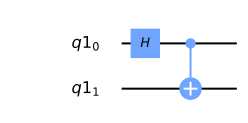

In [3]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


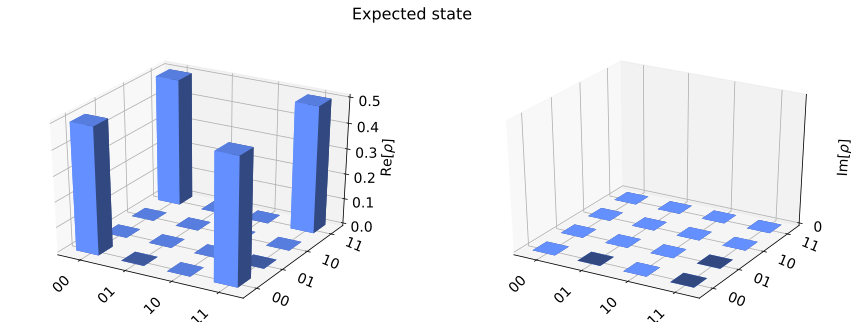

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

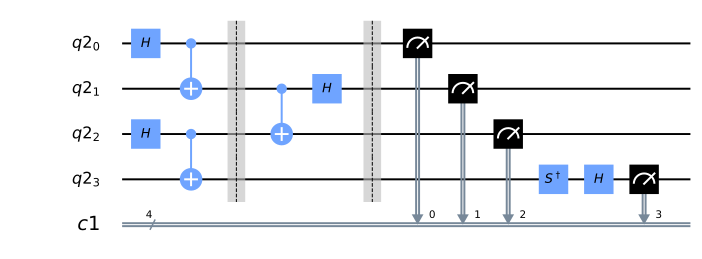

In [5]:
qr = QuantumRegister(4)
cr= ClassicalRegister(4)
qc1 = QuantumCircuit(qr)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qcz=state_tomography_circuits(qc1,[qr])
qct=[qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]
qct[7].draw(output='mpl')

In [6]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qct[8].qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192,optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


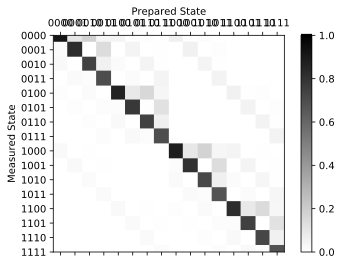

[0.00474237 0.0811056  0.0324576  0.79002191]
[ 8.30219185e-02  5.03710524e-04  8.69940410e-01 -1.87876179e-04]
[[ 5.03710524e-04  8.69940410e-01 -1.87876179e-04]
 [ 9.02732998e-01 -5.24135227e-05  2.43625459e-03]
 [ 8.11055987e-02  3.24576033e-02  7.90021910e-01]]
-0.00018787617921151023


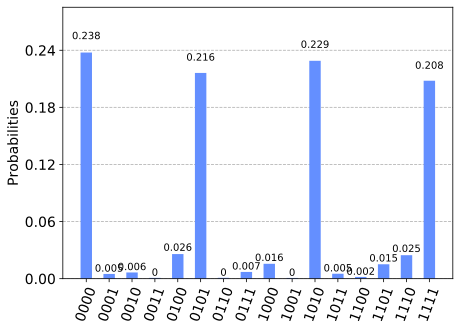

In [69]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
counts =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101', '1101', '0110', '1110', '0111', '1111']
for i in range(0,16):
    counts[i]=calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0
countsdev = {'0000':counts[0]["0000"]+counts[0]["0010"]+counts[0]["0100"]+counts[0]["0110"]+
             counts[2]["0000"]+counts[2]["0010"]+counts[2]["0100"]+counts[2]["0110"]+
             counts[4]["0000"]+counts[4]["0010"]+counts[4]["0100"]+counts[4]["0110"]+
             counts[6]["0000"]+counts[6]["0010"]+counts[6]["0100"]+counts[6]["0110"],
             '0001':counts[0]["0001"]+counts[0]["0011"]+counts[0]["0101"]+counts[0]["0111"]+
             counts[2]["0001"]+counts[2]["0011"]+counts[2]["0101"]+counts[2]["0111"]+
             counts[4]["0001"]+counts[4]["0011"]+counts[4]["0101"]+counts[4]["0111"]+
             counts[6]["0001"]+counts[6]["0011"]+counts[6]["0101"]+counts[6]["0111"],
             '0010':counts[0]["1000"]+counts[0]["1010"]+counts[0]["1100"]+counts[0]["1110"]+
             counts[2]["1000"]+counts[2]["1010"]+counts[2]["1100"]+counts[2]["1110"]+
             counts[4]["1000"]+counts[4]["1010"]+counts[4]["1100"]+counts[4]["1110"]+
             counts[6]["1000"]+counts[6]["1010"]+counts[6]["1100"]+counts[6]["1110"],
             '0011':counts[0]["1001"]+counts[0]["1011"]+counts[0]["1100"]+counts[0]["1110"]+
             counts[2]["1001"]+counts[2]["1011"]+counts[2]["1101"]+counts[2]["1111"]+
             counts[4]["1001"]+counts[4]["1011"]+counts[4]["1101"]+counts[4]["1111"]+
             counts[6]["1001"]+counts[6]["1011"]+counts[6]["1101"]+counts[6]["1111"],
             '0100':counts[1]["0000"]+counts[1]["0010"]+counts[1]["0100"]+counts[1]["0110"]+
             counts[3]["0000"]+counts[3]["0010"]+counts[3]["0100"]+counts[3]["0110"]+
             counts[5]["0000"]+counts[5]["0010"]+counts[5]["0100"]+counts[5]["0110"]+
             counts[7]["0000"]+counts[7]["0010"]+counts[7]["0100"]+counts[7]["0110"],
             '0101':counts[1]["0001"]+counts[1]["0011"]+counts[1]["0101"]+counts[1]["0111"]+
             counts[3]["0001"]+counts[3]["0011"]+counts[3]["0101"]+counts[3]["0111"]+
             counts[5]["0001"]+counts[5]["0011"]+counts[5]["0101"]+counts[5]["0111"]+
             counts[7]["0001"]+counts[7]["0011"]+counts[7]["0101"]+counts[7]["0111"],
             '0110':counts[1]["1000"]+counts[1]["1010"]+counts[1]["1100"]+counts[1]["1110"]+
             counts[3]["1000"]+counts[3]["1010"]+counts[3]["1100"]+counts[3]["1110"]+
             counts[5]["1000"]+counts[5]["1010"]+counts[5]["1100"]+counts[5]["1110"]+
             counts[7]["1000"]+counts[7]["1010"]+counts[7]["1100"]+counts[7]["1110"],
             '0111':counts[1]["1001"]+counts[1]["1011"]+counts[1]["1100"]+counts[1]["1110"]+
             counts[3]["1001"]+counts[3]["1011"]+counts[3]["1101"]+counts[3]["1111"]+
             counts[5]["1001"]+counts[5]["1011"]+counts[5]["1101"]+counts[5]["1111"]+
             counts[7]["1001"]+counts[7]["1011"]+counts[7]["1101"]+counts[7]["1111"],
             '1000':counts[8]["0000"]+counts[8]["0010"]+counts[8]["0100"]+counts[8]["0110"]+
             counts[10]["0000"]+counts[10]["0010"]+counts[10]["0100"]+counts[10]["0110"]+
             counts[12]["0000"]+counts[12]["0010"]+counts[12]["0100"]+counts[12]["0110"]+
             counts[14]["0000"]+counts[14]["0010"]+counts[14]["0100"]+counts[14]["0110"],
             '1001':counts[8]["0001"]+counts[8]["0011"]+counts[8]["0101"]+counts[8]["0111"]+
             counts[10]["0001"]+counts[10]["0011"]+counts[10]["0101"]+counts[10]["0111"]+
             counts[12]["0001"]+counts[12]["0011"]+counts[12]["0101"]+counts[12]["0111"]+
             counts[14]["0001"]+counts[14]["0011"]+counts[14]["0101"]+counts[14]["0111"],
             '1010':counts[8]["1000"]+counts[8]["1010"]+counts[8]["1100"]+counts[8]["1110"]+
             counts[10]["1000"]+counts[10]["1010"]+counts[10]["1100"]+counts[10]["1110"]+
             counts[12]["1000"]+counts[12]["1010"]+counts[12]["1100"]+counts[12]["1110"]+
             counts[14]["1000"]+counts[14]["1010"]+counts[14]["1100"]+counts[14]["1110"],
             '1011':counts[8]["1001"]+counts[8]["1011"]+counts[8]["1100"]+counts[8]["1110"]+
             counts[10]["1001"]+counts[10]["1011"]+counts[10]["1101"]+counts[10]["1111"]+
             counts[12]["1001"]+counts[12]["1011"]+counts[12]["1101"]+counts[12]["1111"]+
             counts[14]["1001"]+counts[14]["1011"]+counts[14]["1101"]+counts[14]["1111"],
             '1100':counts[9]["0000"]+counts[9]["0010"]+counts[9]["0100"]+counts[9]["0110"]+
             counts[11]["0000"]+counts[11]["0010"]+counts[11]["0100"]+counts[11]["0110"]+
             counts[13]["0000"]+counts[13]["0010"]+counts[13]["0100"]+counts[13]["0110"]+
             counts[15]["0000"]+counts[15]["0010"]+counts[15]["0100"]+counts[15]["0110"],
             '1101':counts[9]["0001"]+counts[9]["0011"]+counts[9]["0101"]+counts[9]["0111"]+
             counts[11]["0001"]+counts[11]["0011"]+counts[11]["0101"]+counts[11]["0111"]+
             counts[13]["0001"]+counts[13]["0011"]+counts[13]["0101"]+counts[13]["0111"]+
             counts[15]["0001"]+counts[15]["0011"]+counts[15]["0101"]+counts[15]["0111"],
             '1110':counts[9]["1000"]+counts[9]["1010"]+counts[9]["1100"]+counts[9]["1110"]+
             counts[11]["1000"]+counts[11]["1010"]+counts[11]["1100"]+counts[11]["1110"]+
             counts[13]["1000"]+counts[13]["1010"]+counts[13]["1100"]+counts[13]["1110"]+
             counts[15]["1000"]+counts[15]["1010"]+counts[15]["1100"]+counts[15]["1110"],
             '1111':counts[9]["1001"]+counts[9]["1011"]+counts[9]["1100"]+counts[9]["1110"]+
             counts[11]["1001"]+counts[11]["1011"]+counts[11]["1101"]+counts[11]["1111"]+
             counts[13]["1001"]+counts[13]["1011"]+counts[13]["1101"]+counts[13]["1111"]+
             counts[15]["1001"]+counts[15]["1011"]+counts[15]["1101"]+counts[15]["1111"]}
m00= (countsdev["0000"]*1 + countsdev["0001"]*(-1)+countsdev["0010"]*(-1)+countsdev["0011"]*1)/(countsdev["0000"]+countsdev["0001"]+countsdev["0010"]+countsdev["0011"])
m01= (countsdev["0100"]*1 + countsdev["0101"]*(-1)+countsdev["0110"]*(-1)+countsdev["0111"]*1)/(countsdev["0100"]+countsdev["0101"]+countsdev["0110"]+countsdev["0111"])
m10= (countsdev["1000"]*1 + countsdev["1001"]*(-1)+countsdev["1010"]*(-1)+countsdev["1011"]*1)/(countsdev["1000"]+countsdev["1001"]+countsdev["1010"]+countsdev["1011"])
m11= (countsdev["1100"]*1 + countsdev["1101"]*(-1)+countsdev["1110"]*(-1)+countsdev["1111"]*1)/(countsdev["1100"]+countsdev["1101"]+countsdev["1110"]+countsdev["1111"])
minverse=np.array([[0.25,0.25,0.25,0.25],[0.25,0.25,-0.25,-0.25],[0.25,-0.25,0.25,-0.25],[0.25,-0.25,-0.25,0.25]])
beta_corr=np.dot(minverse,np.array([m00,m01,m10,m11]))
m00= (countsdev["0000"]*1 + countsdev["0001"]*(-1)+countsdev["0010"]*(1)+countsdev["0011"]*(-1))/(countsdev["0000"]+countsdev["0001"]+countsdev["0010"]+countsdev["0011"])
m01= (countsdev["0100"]*1 + countsdev["0101"]*(-1)+countsdev["0110"]*(1)+countsdev["0111"]*(-1))/(countsdev["0100"]+countsdev["0101"]+countsdev["0110"]+countsdev["0111"])
m10= (countsdev["1000"]*1 + countsdev["1001"]*(-1)+countsdev["1010"]*(1)+countsdev["1011"]*(-1))/(countsdev["1000"]+countsdev["1001"]+countsdev["1010"]+countsdev["1011"])
m11= (countsdev["1100"]*1 + countsdev["1101"]*(-1)+countsdev["1110"]*(1)+countsdev["1111"]*(-1))/(countsdev["1100"]+countsdev["1101"]+countsdev["1110"]+countsdev["1111"])
beta_m=np.dot(minverse,np.array([m00,m01,m10,m11]))
m00= (countsdev["0000"]*1 + countsdev["0001"]*(1)+countsdev["0010"]*(-1)+countsdev["0011"]*(-1))/(countsdev["0000"]+countsdev["0001"]+countsdev["0010"]+countsdev["0011"])
m01= (countsdev["0100"]*1 + countsdev["0101"]*(1)+countsdev["0110"]*(-1)+countsdev["0111"]*(-1))/(countsdev["0100"]+countsdev["0101"]+countsdev["0110"]+countsdev["0111"])
m10= (countsdev["1000"]*1 + countsdev["1001"]*(1)+countsdev["1010"]*(-1)+countsdev["1011"]*(-1))/(countsdev["1000"]+countsdev["1001"]+countsdev["1010"]+countsdev["1011"])
m11= (countsdev["1100"]*1 + countsdev["1101"]*(1)+countsdev["1110"]*(-1)+countsdev["1111"]*(-1))/(countsdev["1100"]+countsdev["1101"]+countsdev["1110"]+countsdev["1111"])
beta_l=np.dot(minverse,np.array([m00,m01,m10,m11]))
B=np.array([beta_m[1:],beta_l[1:],beta_corr[1:]])
plot_histogram(countsdev)

In [8]:
backends = [simulator,device,0]
result =[0,0,0,0]
paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
for be in range(len(backends)):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    if be == 0:
        job = qiskit.execute(qct, simulator, shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
    if be == 1:
        job = qiskit.execute(qct, device, shots=8192)
        job_monitor(job)
        result[be] = job.result()
    if be == 2:
        tom = StateTomographyFitter(meas_filter.apply(result[be-1]),qct)
    else:
        tom = StateTomographyFitter(job.result(), qct)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}
    if be == 0:
        state_sim = state_df
        print('The full state for simulator is', state_df)
    if be == 1:
        state_dev = state_df
        print('The full state for device is', state_df)
        x=0
    if be == 2:
        state_err = state_df
        print('The corrected state for device is', state_df)

The full state for simulator is                                              XX  \
0  {'00': 997, '10': 181, '01': 149, '11': 895}   
1   {'00': 129, '10': 886, '01': 911, '11': 90}   
2  {'00': 930, '10': 166, '01': 142, '11': 865}   
3   {'00': 125, '10': 855, '01': 791, '11': 80}   

                                             YX  \
0  {'00': 574, '10': 582, '01': 551, '11': 492}   
1  {'00': 531, '10': 520, '01': 542, '11': 480}   
2  {'00': 542, '10': 469, '01': 502, '11': 490}   
3  {'00': 506, '10': 517, '01': 455, '11': 439}   

                                             ZX  \
0  {'00': 604, '10': 626, '01': 539, '11': 505}   
1  {'00': 555, '10': 533, '01': 483, '11': 464}   
2  {'00': 551, '10': 513, '01': 455, '11': 468}   
3  {'00': 483, '10': 521, '01': 436, '11': 456}   

                                             XY  \
0  {'00': 574, '10': 567, '01': 535, '11': 518}   
1  {'00': 547, '10': 533, '01': 472, '11': 486}   
2  {'00': 531, '10': 519, '01': 494, '11': 527}

In [9]:
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

r_exp=np.zeros((4, 9))
ri_exp=np.zeros((4, 9))
ri2_exp=np.zeros((4, 9))
riav_exp=np.zeros((4, 3))
riav2_exp=np.zeros((4, 3))
state_tot=[state_sim,state_dev,state_err]
rhof=[0,0,0,0]
rho2=[0,0,0]
basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

for stat in range(len(state_tot)):
    rhof=[0,0,0,0]
    for i in range(4):
        for j in range(9):
            r_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(-1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*1)/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
            ri_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*(-1))/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
            ri2_exp[i,j] = (state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(-1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*(-1))/(state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*1)
    for i in range(4):
        for j in range(3):
            riav_exp[i,j]=(ri_exp[i,3*j]+ri_exp[i,3*j+1]+ri_exp[i,3*j+2])/3
            riav2_exp[i,j]=(ri2_exp[i,3*j]+ri2_exp[i,3*j+1]+ri2_exp[i,3*j+2])/3
    for i in range(4):
        rhof[i] = (1/4)*(Iden+r_exp[i,0]*XXPaul+r_exp[i,1]*XYPaul+r_exp[i,2]*XZPaul+
                          r_exp[i,3]*YXPaul+r_exp[i,4]*YYPaul+r_exp[i,5]*YZPaul+r_exp[i,6]*ZXPaul+
                          r_exp[i,7]*ZYPaul+r_exp[i,8]*ZZPaul+riav_exp[i,0]*IXPaul+riav2_exp[i,0]*XIPaul+
                          riav_exp[i,1]*IYPaul+riav2_exp[i,1]*YIPaul+riav_exp[i,2]*IZPaul+
                          riav2_exp[i,2]*ZIPaul)
    rho2[stat]=rhof
rho = pd.DataFrame(data=[rho2[0],rho2[1],rho2[2]])
for ind in range(3):
    rho.loc[ind][1] = ZIPaul @ rho.loc[ind][1] @ ZIPaul
    rho.loc[ind][2] = XIPaul @ rho.loc[ind][2] @ XIPaul
    rho.loc[ind][3] = XIPaul @ ZIPaul @ rho.loc[ind][3] @ ZIPaul @ XIPaul  

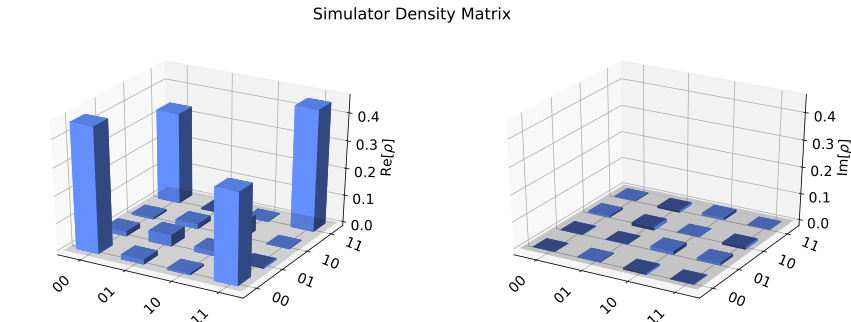

In [10]:
finstate= rho[2][0]
plot_state_city(finstate, title='Simulator Density Matrix')

In [11]:
Fidelity = np.zeros((3,4))
for i in range(3):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)     
F = np.mean(Fidelity,axis=1)
print('Noisy Simulator Fidelity:', F[0])
print('Device Fidelity:', F[1])
print('Corrected Device Fidelity:', F[2])

Noisy Simulator Fidelity: 0.7941101245018389
Device Fidelity: 0.5442369250483605
Corrected Device Fidelity: 0.6896876715330786
